<a href="https://colab.research.google.com/github/dzubii/Assignments/blob/master/Keras_Deep_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q wrapt
!pip install -q tf-nightly

     |████████████████████████████████| 100.1MB 227kB/s 
     |████████████████████████████████| 3.9MB 34.7MB/s 
     |████████████████████████████████| 501kB 35.2MB/s 
     |████████████████████████████████| 61kB 15.1MB/s 


In [0]:
from __future__ import absolute_import, division, print_function
from tqdm import tqdm

import os
import cv2
import tensorflow as tf
import numpy as np
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

#tf.compat.v1.disable_eager_execution()
tf.VERSION

Using TensorFlow backend.
W0714 18:41:01.692152 139714521147264 module_wrapper.py:126] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:153: The name tf.VERSION is deprecated. Please use tf.version.VERSION instead.



'1.15.0-dev20190714'

In [0]:
import pathlib
data_root = tf.keras.utils.get_file('flower_photos','http://download.tensorflow.org/example_images/flower_photos.tgz', untar=True)
data_root = pathlib.Path(data_root)
print(data_root)

228818944/228813984 [==============================] - 7s 0us/step
/root/.keras/datasets/flower_photos


In [0]:
for item in data_root.iterdir():
  print(item)

/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/LICENSE.txt
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/sunflowers


In [0]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

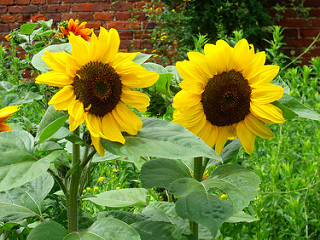

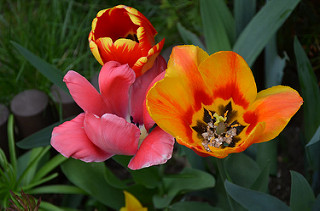

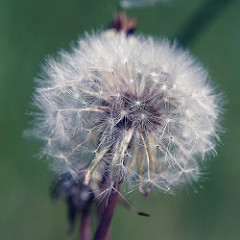

In [0]:
import IPython.display as display

for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  #print(caption_image(image_path))
  print()

In [0]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [0]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [0]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [1, 1, 3, 3, 2, 0, 2, 3, 3, 0]


In [0]:
img_path = all_image_paths[0]
img_path

'/root/.keras/datasets/flower_photos/dandelion/17346385582_7ba433dbbe.jpg'

In [0]:
X=[]
y=[]
IMG_SIZE=150

DAISY_DIR='../root/.keras/datasets/flower_photos/daisy'
SUNFLOWER_DIR='../root/.keras/datasets/flower_photos/sunflowers'
TULIP_DIR='../root/.keras/datasets/flower_photos/tulips'
DANDELION_DIR='../root/.keras/datasets/flower_photos/dandelion'
ROSE_DIR='../root/.keras/datasets/flower_photos/roses'

def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        y.append(str(label_names))

In [0]:
make_train_data('Daisy',DAISY_DIR)
make_train_data('Sunflowers',SUNFLOWER_DIR)
make_train_data('Tulips',TULIP_DIR)
make_train_data('Dandelion',DANDELION_DIR)
make_train_data('Roses',ROSE_DIR)
print(len(X))

100%|██████████| 641/641 [00:01<00:00, 333.62it/s]

3670


In [0]:
os.listdir(DAISY_DIR)

In [0]:
labelEncoder=LabelEncoder()
#y=labelEncoder.fit_transform(y)
y=to_categorical(y,5)
X=np.array(X)
X
#X=X/255

In [0]:
print(X.shape)
print(y.shape)

(3670, 150, 150, 3)
(3670, 5)


In [0]:
X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,test_size=0.25,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.10,random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_train_val.shape)
print(y_train_val.shape)
print(X_val.shape)
print(y_val.shape)

(2476, 150, 150, 3)
(2476, 5)
(2752, 150, 150, 3)
(2752, 5)
(276, 150, 150, 3)
(276, 5)


# **Model 1**

In [0]:
from keras import applications
image_w, image_h = 150, 150
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
model.summary()

W0616 19:30:15.666815 140141225600896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 19:30:15.719515 140141225600896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 19:30:15.728081 140141225600896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 19:30:15.793015 140141225600896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 1s 0us/step


W0616 19:30:17.207728 140141225600896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0616 19:30:17.209083 140141225600896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
for layer in model.layers:
    layer.trainable = False
    
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [0]:
def Revised_1_fn(learn_rate=0.01): 
    last = model.output
    x = Flatten()(last)
    x = Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    preds = Dense(5, activation='softmax')(x)

    Revised_Model_1 = Model(model.input, preds)
    Revised_Model_1.summary()
    Revised_Model_1.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return Revised_Model_1

In [0]:
#

In [0]:
#

# **Model 2**

In [0]:
for layer in model.layers[15:]:
    layer.trainable = True
     
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [0]:
def Revised_2_fn(learn_rate=0.01):
    last = model.output
    x = Flatten()(last)
    x = Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    preds = Dense(5, activation='softmax')(x)

    Revised_Model_2 = Model(model.input, preds)
    Revised_Model_2.summary()
    Revised_Model_2.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return Revised_Model_2

# **Model 3**

In [0]:
for layer in model.layers:
    layer.trainable = True
     
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [0]:
def Revised_3_fn(learn_rate=0.01): 
    last = model.output
    x = Flatten()(last)
    x = Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    preds = Dense(5, activation='softmax')(x)

    Revised_Model_3 = Model(model.input, preds)
    Revised_Model_3.summary()
    Revised_Model_3.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return Revised_Model_3

In [0]:
#using Grid Search and Early stopping
es = EarlyStopping(monitor='val_acc', verbose=2, patience=25)
mc = ModelCheckpoint('./best_model_1.h5', monitor='val_acc', verbose=2, save_best_only=True)

Hyp_Model_1 = KerasClassifier(build_fn=Revised_1_fn)
#You need to pick the right hyper-parameters for your training (try with different ones)

learn_rate = [0.01]
batch_size = [32,75,100]
epochs = [5]

param_grid = dict(batch_size=batch_size, epochs=epochs, learn_rate = learn_rate)
randSearch_1 = GridSearchCV(estimator = Hyp_Model_1, param_grid=param_grid, cv=5)

In [0]:
new_grid_1 = randSearch_1.fit(X_train,y_train, validation_data = (X_val, y_val), verbose=2,callbacks=[es,mc])